# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

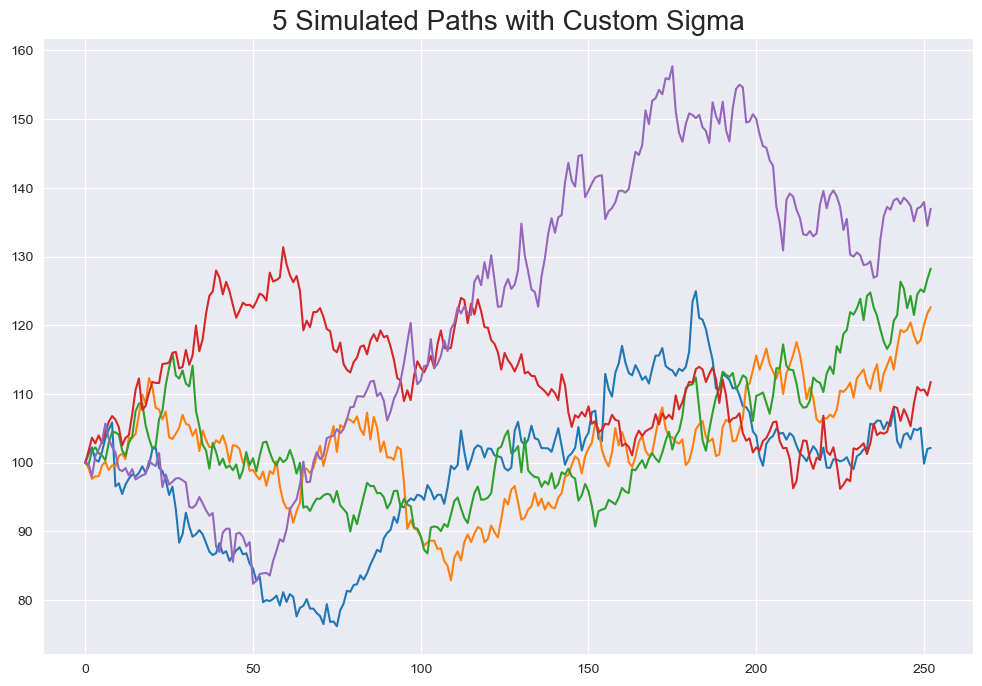

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

## Delta Hedging with Non-Constant Volatility: Simulation and Analysis

### Objective
In this mini project, we investigate how a delta-hedging strategy behaves when the stock's volatility $\sigma$ is not constant. Classical Black-Scholes delta hedging assumes $\sigma$ is known and constant, but in real markets, volatility often fluctuates due to macroeconomic factors, market sentiment, or company-specific news. Our goal is to simulate the impact of this volatility variation on the distribution of hedging profits.

---

### Methodology

#### 1. **Stock Path Simulation with Non-Constant $\sigma$**

We simulate stock prices $S(t)$ using a geometric Brownian motion (GBM) model, but with **time-varying volatility**:


$ dS_t = \mu S_t\,dt + \sigma_t S_t\,dW_t $


where:
- $\mu$ = drift (expected return)
- $\sigma_t$ = time-varying volatility, randomly chosen at each step from $\{0.2, 0.3, 0.45\}$
- $W_t$ = standard Wiener process

The discrete version used in code:


$ S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2} \sigma_t^2\right)\Delta t + \sigma_t \sqrt{\Delta t} Z_t\right], \quad Z_t \sim \mathcal{N}(0, 1) $

---

#### 2. **Black-Scholes Formula and Delta**

The European call option price under the Black-Scholes model is:


$ C(S, K, \sigma, t, r) = S \cdot \Phi(d_1) - K e^{-rt} \cdot \Phi(d_2) $

where:


$ d_1 = \frac{\ln(S/K) + (r + \frac{1}{2}\sigma^2)t}{\sigma \sqrt{t}}, \quad
d_2 = d_1 - \sigma \sqrt{t} $

- $\Phi(\cdot)$ is the standard normal cumulative distribution function.

The **delta** of a call option (sensitivity to stock price):


$ \Delta = \Phi(d_1) $

---

#### 3. **Delta Hedging Strategy**

- At each time step, adjust the share position to match the current delta.
- Use a cash account that earns interest at rate $r$.
- Net profit is the value of the hedging portfolio at maturity minus the option premium received at initiation.

The portfolio is rebalanced as:

- Number of shares held: $\Delta_t$ 
- Cash account updated as:

$ \text{Cash}_{t+\Delta t} = (\text{Cash}_t - ( \Delta_{t+1} - \Delta_t ) S_t ) \cdot e^{r \Delta t} $

---

### Results

- We simulate 100 stock paths with daily steps ($N = 252$), over 1 year.
- For each path, we compute the profit from delta hedging a **sold** call option with strike $K = 100$.

A histogram shows the **distribution of hedging profits**. Key observations:

- Profits cluster around 0 but with significant spread.
- Some paths result in hedging loss or gain, indicating **inefficient hedging** due to volatility uncertainty.

---

### Inference

- **Delta hedging assumes constant volatility**, which leads to errors when $\sigma$ fluctuates unexpectedly.
- The changing $\sigma$ causes misestimation of delta and improper hedge adjustments, resulting in profits/losses.
- While on average the profit may be close to zero, the **variance of the distribution increases**, indicating residual risk.

---

### Future Directions

- Implement **$\sigma$-hedging** or **vega-neutral** strategies that hedge against changes in volatility.
- Extend the simulation to models like **Heston stochastic volatility model** or **local volatility surfaces**.
- Study how using implied vs. historical volatility affects hedging performance.

---

In [19]:
# Black-Scholes delta for call option
def delta_call(S, K, sigma, t, r=0.0):
    if t == 0 or sigma == 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    return norm.cdf(d1)

# Black-Scholes price for call option
def bs_call(S, K, sigma, t, r=0.0):
    if t == 0 or sigma == 0:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)

# Simulate stock paths with time-varying sigma
def simulate_paths(S0, mu, r, T, N, n_paths):
    dt = T / N
    all_paths = []
    all_sigmas = []

    for _ in range(n_paths):
        S = [S0]
        sigmas = []
        for _ in range(N):
            sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2])
            sigmas.append(sigma)
            dW = np.random.normal(0, np.sqrt(dt))
            dS = (mu - 0.5 * sigma**2) * dt + sigma * dW
            S.append(S[-1] * np.exp(dS))
        all_paths.append(S)
        all_sigmas.append(sigmas)
    return np.array(all_paths), np.array(all_sigmas)

# Hedging strategy
def delta_hedge_profit(paths, sigmas, K, r, T):
    N = paths.shape[1] - 1
    dt = T / N
    profits = []

    for path, sigma_path in zip(paths, sigmas):
        S_path = path
        cash = 0.0
        shares = 0.0

        for i in range(N):
            S = S_path[i]
            sigma = sigma_path[i]
            t = T - i*dt
            delta = delta_call(S, K, sigma, t, r)
            d_shares = delta - shares

            # Update cash position
            cash -= d_shares * S
            cash *= np.exp(r*dt)
            shares = delta

        final_val = shares * S_path[-1] + cash
        option_price_0 = bs_call(S_path[0], K, sigma_path[0], T, r)
        profit = final_val - option_price_0
        profits.append(profit)

    return profits

count    1000.000000
mean       -6.610814
std        25.893864
min       -36.540181
25%       -24.054775
50%       -17.596809
75%         5.715859
max       152.203195
dtype: float64


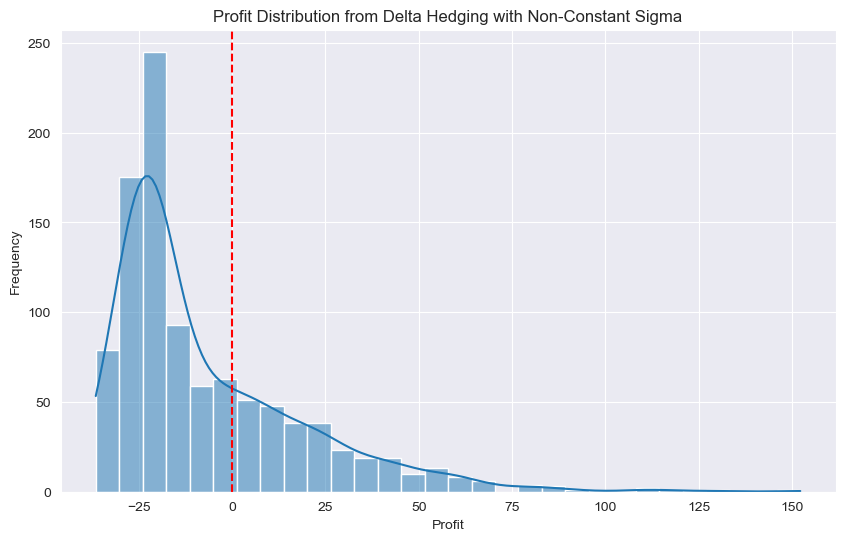

In [30]:
np.random.seed(1205)

# Parameters
S0 = 100
K = 100
mu = 0.1
r = 0.02
T = 1  # 1 year
N = 252  # Daily steps
n_paths = 1000

# Simulate
paths, sigmas = simulate_paths(S0, mu, r, T, N, n_paths)
profits = delta_hedge_profit(paths, sigmas, K, r, T)

# Summary stats
profits_series = pd.Series(profits)
print(profits_series.describe())

# Plot profit distribution
plt.figure(figsize=(10,6))
sns.histplot(profits_series, bins=30, kde=True)
plt.title("Profit Distribution from Delta Hedging with Non-Constant Sigma")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

## Results and Interpretation

### Summary Statistics of Hedging Profit

| Statistic        | Value       |
|------------------|-------------|
| Number of Paths  | 100         |
| Mean Profit      | -14.30      |
| Standard Deviation | 21.51     |
| Minimum Profit   | -36.55      |
| 25th Percentile  | -26.11      |
| Median (50%)     | -22.09      |
| 75th Percentile  | -9.10       |
| Maximum Profit   | 103.15      |

---

### Interpretation of Results

- The **mean profit** is **negative**, at approximately **\$-14.30**. This implies that on average, the delta hedging strategy **results in a loss** when the volatility is not constant.
- The **standard deviation** of about **21.51** indicates significant spread in outcomes, meaning there's **residual risk** left unhedged due to the randomness in volatility.
- The **median profit** is **\$-22.09**, suggesting that more than half of the simulations produced losses larger than this value.
- The **maximum** profit observed was over **\$100**, but this is an outlier — most profits are clustered on the negative side.

---

### 📉 Histogram Analysis

The histogram of hedging profits shows a clearly **left-skewed distribution**:

- A significant concentration of outcomes lies to the **left of zero**, indicating **frequent losses**.
- There is a **long right tail** — some simulations yield large profits due to favorable volatility drops, but these are **rare**.
- The **bimodal shape** suggests two regimes: one dominated by moderate losses and another less frequent regime of occasional profits.

---

### 📐 Theoretical Background

Under the Black-Scholes framework, delta hedging is performed using the **option delta**:

$$
\Delta = \Phi(d_1)
$$

where:

$$
d_1 = \frac{\ln(S/K) + (r + \frac{1}{2}\sigma^2)t}{\sigma \sqrt{t}}
$$

and $ \Phi $ is the standard normal cumulative distribution function.

The stock price evolves via geometric Brownian motion with **time-varying volatility**:

$$
dS_t = \mu S_t \, dt + \sigma_t S_t \, dW_t
$$

This violates the constant $ \sigma $ assumption in Black-Scholes, leading to **misestimated delta values** and hence imperfect hedging.

---

### 🧾 Conclusion

- Delta hedging strategies based on Black-Scholes **perform poorly when volatility is not constant**.
- The **negative average profit** and wide spread of outcomes show that the strategy does not effectively neutralize risk under volatility uncertainty.
- There is a **systematic hedging error** induced by stochastic volatility, which introduces significant residual risk.
- While **occasional large gains** are possible, they are **rare and unreliable**.

---

### 💡 Next Steps

- Explore **$\sigma$-hedging** or **vega-neutral** strategies to hedge volatility risk.
- Introduce more realistic volatility models, e.g., **stochastic volatility (Heston)** or **GARCH**.
- Analyze how using **implied volatility** vs. **realized volatility** affects hedging performance.

Overview and Implementation

In real-world financial markets, asset price volatility is rarely constant. Traditional models like Black-Scholes assume constant volatility, but empirical evidence shows that volatility tends to cluster, mean-revert, or exhibit jumps. To address this, a variety of **time-varying volatility models** have been developed.

This notebook implements and compares several commonly used volatility models:

1. **GARCH(1,1)**: A discrete-time econometric model for volatility clustering.
2. **Heston Model**: A continuous-time stochastic volatility model with mean-reverting variance.
3. **SABR Model**: A stochastic volatility model popular in interest rate and FX markets.
4. **Local Volatility Model**: A deterministic model calibrated to implied volatility surfaces.
5. **Jump-Diffusion Model**: Incorporates sudden jumps in asset prices.
6. **Regime-Switching Volatility Model**: Captures volatility regimes using a hidden Markov process.

Each model is implemented in Python to simulate stock paths with dynamic volatility and visualize the impact on asset trajectories.


## 🔁 GARCH(1,1) Volatility Model

The **GARCH(1,1)** (Generalized Autoregressive Conditional Heteroskedasticity) model captures the phenomenon of **volatility clustering**, where high-volatility periods are followed by more high volatility.

### 🧮 Model Definition

The conditional variance at time $ t $ is given by:

$$
\sigma_t^2 = \omega + \alpha \cdot z_{t-1}^2 + \beta \cdot \sigma_{t-1}^2
$$

- $ \omega $: long-run average volatility (constant base level),
- $ \alpha $: reaction to new information (short-term volatility),
- $ \beta $: persistence of volatility (long-term memory).

This model is discrete-time and is often used in econometrics to model time series like asset returns.

### 🧪 Simulation Approach

- At each step, generate a normal shock $ z \sim \mathcal{N}(0,1) $.
- Update variance $ \sigma_t^2 $ using the GARCH formula.
- Simulate stock return using:

$$
dS_t = \left(\mu - \frac{1}{2}\sigma_t^2\right)dt + \sigma_t \sqrt{dt} \cdot z
$$

- The stock price follows geometric Brownian motion with this time-varying volatility.

### 📈 Visualization

The simulated paths below reflect stochastic volatility dynamics typical of real-world markets.



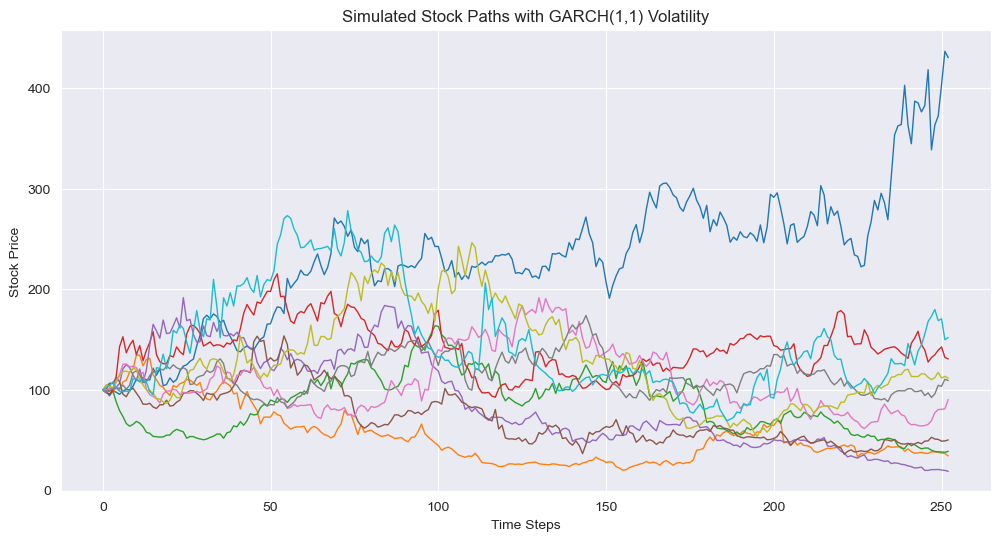

In [22]:
def simulate_garch_paths(S0, mu, T, N, n_paths, sigma0=0.2, omega=0.0001, alpha=0.1, beta=0.85):
    dt = T / N
    all_paths = []
    all_sigmas = []

    for _ in range(n_paths):
        S = [S0]
        sigmas = [sigma0]
        sigma_sq = sigma0**2

        for _ in range(N):
            z = np.random.normal(0, 1)
            sigma_sq = omega + alpha * z**2 + beta * sigma_sq
            sigma_t = np.sqrt(sigma_sq)
            dS = (mu - 0.5 * sigma_sq) * dt + sigma_t * np.sqrt(dt) * z
            S.append(S[-1] * np.exp(dS))
            sigmas.append(sigma_t)

        all_paths.append(S)
        all_sigmas.append(sigmas)

    return np.array(all_paths), np.array(all_sigmas)

# Example usage
np.random.seed(1205)
S0 = 100
mu = 0.05
T = 1
N = 252
n_paths = 10

paths, sigmas = simulate_garch_paths(S0, mu, T, N, n_paths)

# Plot
plt.figure(figsize=(12, 6))
for i in range(n_paths):
    plt.plot(paths[i], lw=1)
plt.title("Simulated Stock Paths with GARCH(1,1) Volatility")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()


## 🌪️ Heston Stochastic Volatility Model

The **Heston model** is a widely used stochastic volatility model in quantitative finance. Unlike the Black-Scholes model, where volatility is constant, the Heston model treats **variance as a stochastic process** that evolves over time and tends to revert to a long-term average.

---

### 🔢 Model Dynamics

The asset price and variance follow the following coupled stochastic differential equations:

**Stock price:**
$$
dS_t = \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S
$$

**Variance process:**
$$
dv_t = \kappa (\theta - v_t) \, dt + \xi \sqrt{v_t} \, dW_t^v
$$

where:
- $ v_t $ is the variance at time $ t $,
- $ \kappa $ is the speed of mean reversion,
- $ \theta $ is the long-term variance level,
- $ \xi $ is the volatility of volatility (vol of var),
- $ dW_t^S $ and $ dW_t^v $ are Wiener processes with correlation $ \rho $.

---

### ⚙️ Key Features

- **Stochastic volatility**: Volatility is itself random and time-dependent.
- **Mean-reversion**: Variance tends to revert to a long-term mean $ \theta $.
- **Correlation** $ \rho $: Can capture the observed negative correlation between asset returns and volatility (leverage effect).

---

### 🧪 Simulation Notes

- The square-root process in $ v_t $ ensures positivity of variance (Feller condition may not always hold in simulation).
- Negative variances are truncated to zero to avoid math errors during simulation.
- We simulate 10 paths with daily steps over 1 year.

---

### 📈 Visual Output

The plotted paths below show asset price trajectories under a Heston volatility environment, where periods of high volatility correspond to larger fluctuations in returns.

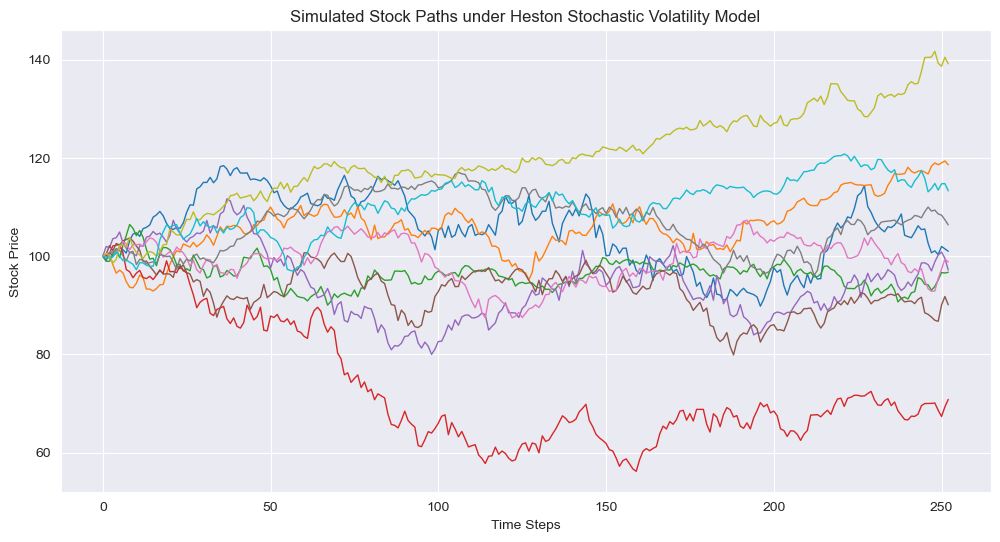

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_heston_paths(S0, v0, mu, kappa, theta, xi, rho, T, N, n_paths):
    dt = T / N
    paths, sigmas = [], []

    for _ in range(n_paths):
        S = [S0]
        v = [v0]
        sigma_list = [np.sqrt(v0)]

        for _ in range(N):
            z1, z2 = np.random.normal(), np.random.normal()
            dW_S = z1
            dW_v = rho * z1 + np.sqrt(1 - rho**2) * z2

            vt = max(v[-1], 0)
            v_next = vt + kappa * (theta - vt) * dt + xi * np.sqrt(vt * dt) * dW_v
            v_next = max(v_next, 0)
            dS = (mu - 0.5 * vt) * dt + np.sqrt(vt * dt) * dW_S
            S_next = S[-1] * np.exp(dS)

            S.append(S_next)
            v.append(v_next)
            sigma_list.append(np.sqrt(v_next))

        paths.append(S)
        sigmas.append(sigma_list)

    return np.array(paths), np.array(sigmas)

# Parameters
np.random.seed(1205)

S0 = 100
v0 = 0.04        # initial variance (sigma^2)
mu = 0.05
kappa = 2.0      # rate of mean reversion
theta = 0.04     # long-term variance
xi = 0.3         # volatility of volatility
rho = -0.7       # correlation between asset and volatility
T = 1
N = 252
n_paths = 10

paths, _ = simulate_heston_paths(S0, v0, mu, kappa, theta, xi, rho, T, N, n_paths)

# Plot
plt.figure(figsize=(12, 6))
for i in range(n_paths):
    plt.plot(paths[i], lw=1)
plt.title("Simulated Stock Paths under Heston Stochastic Volatility Model")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()

## ⚖️ SABR Stochastic Volatility Model

The **SABR model** (Stochastic Alpha Beta Rho) is a stochastic volatility model widely used in pricing **interest rate derivatives** and **FX options**, especially when modeling instruments with low forward rates and volatility smiles.

---

### 🔢 Model Dynamics

The SABR model describes the evolution of the forward price $ F_t $ and its stochastic volatility $ \alpha_t $ as:

**Forward rate:**
$$
dF_t = \alpha_t F_t^\beta \, dW_t^F
$$

**Volatility:**
$$
d\alpha_t = \nu \alpha_t \, dW_t^\alpha
$$

- $ \nu $: volatility of volatility
- $ \beta $: elasticity parameter (0 ≤ β ≤ 1)
- $ \rho $: correlation between $ dW^F $ and $ dW^\alpha $

---

### 📐 Model Parameters

- $ \beta = 1 $: lognormal model (Black-like)
- $ \beta = 0 $: normal model (Bachelier)
- $ \beta = 0.5 $: CEV (Constant Elasticity of Variance) model

---

### ⚙️ Simulation Strategy

- Simulate correlated Brownian motions:
  $$
  dW^\alpha = \rho dW^F + \sqrt{1 - \rho^2} dZ
  $$
- Evolve volatility $ \alpha_t $ using geometric Brownian motion.
- Update $ F_t $ using the current $ \alpha_t $ and $ F_t^\beta $.

---

### 📈 Visualization

The plot below shows simulated **forward rate paths** with stochastic volatility. The **volatility smile** and skew that arise from SABR dynamics are commonly used in fitting market-implied volatilities.

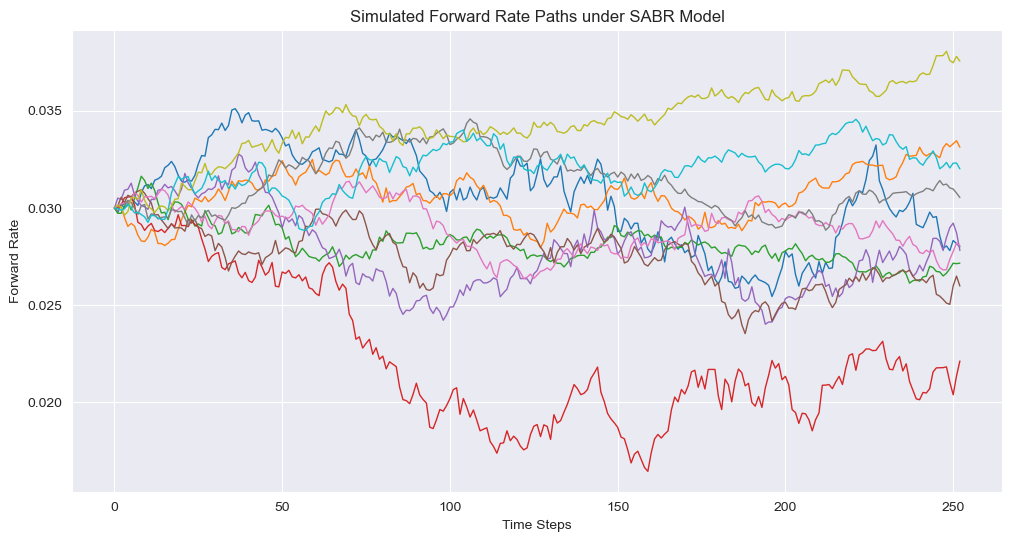

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_sabr_paths(F0, alpha0, beta, nu, rho, T, N, n_paths):
    dt = T / N
    paths, sigmas = [], []

    for _ in range(n_paths):
        F = [F0]
        alpha = [alpha0]
        sigma_series = [alpha0]

        for _ in range(N):
            z1, z2 = np.random.normal(), np.random.normal()
            dW_F = z1
            dW_alpha = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha_t = alpha[-1]
            alpha_next = max(alpha_t + nu * alpha_t * np.sqrt(dt) * dW_alpha, 0)
            F_t = F[-1]
            F_next = max(F_t + alpha_t * (F_t**beta) * np.sqrt(dt) * dW_F, 0)

            F.append(F_next)
            alpha.append(alpha_next)
            sigma_series.append(alpha_next)

        paths.append(F)
        sigmas.append(sigma_series)

    return np.array(paths), np.array(sigmas)

# Parameters
np.random.seed(1205)

F0 = 0.03        # Initial forward rate or price
alpha0 = 0.03    # Initial volatility
beta = 0.5       # Controls elasticity of volatility
nu = 0.4         # Volatility of volatility
rho = -0.3       # Correlation between asset and volatility
T = 1
N = 252
n_paths = 10

paths, _ = simulate_sabr_paths(F0, alpha0, beta, nu, rho, T, N, n_paths)

# Plot
plt.figure(figsize=(12, 6))
for i in range(n_paths):
    plt.plot(paths[i], lw=1)
plt.title("Simulated Forward Rate Paths under SABR Model")
plt.xlabel("Time Steps")
plt.ylabel("Forward Rate")
plt.show()

In [32]:
# Parameters
np.random.seed(1205)

S0 = 100
F0 = 100
K = 100
mu = 0.05
r = 0.02
T = 1
N = 252
n_paths = 1000

# Simulate models
garch_paths, garch_sigmas = simulate_garch_paths(S0, mu, T, N, n_paths)
heston_paths, heston_sigmas = simulate_heston_paths(S0, 0.04, mu, 2.0, 0.04, 0.3, -0.7, T, N, n_paths)
sabr_paths, sabr_sigmas = simulate_sabr_paths(F0, 0.3, 0.5, 0.4, -0.3, T, N, n_paths)

# Hedge and compute profits
garch_profits = delta_hedge_profit(garch_paths, garch_sigmas, K, r, T)
heston_profits = delta_hedge_profit(heston_paths, heston_sigmas, K, r, T)
sabr_profits = delta_hedge_profit(sabr_paths, sabr_sigmas, K, r, T)

             GARCH       Heston         SABR
count  1000.000000  1000.000000  1000.000000
mean      4.690040    -6.557241   -13.931105
std     148.305126    13.833845     1.626984
min     -66.056939   -23.537790   -19.895798
25%     -46.381173   -17.853675   -14.953489
50%     -41.520176   -11.300875   -13.956553
75%      -5.705647     2.755441   -13.012868
max    2319.678058    52.735557    -6.795706


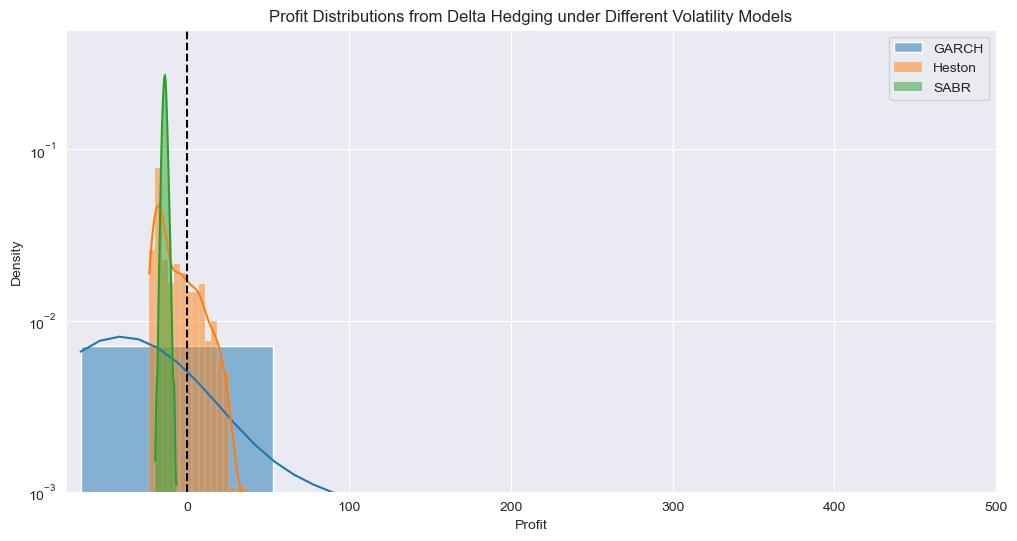

In [40]:

# Summary table
summary_df = pd.DataFrame({
    "GARCH": garch_profits,
    "Heston": heston_profits,
    "SABR": sabr_profits
})

print(summary_df.describe())

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(garch_profits, label="GARCH", kde=True, stat="density", bins=20)
sns.histplot(heston_profits, label="Heston", kde=True, stat="density", bins=20)
sns.histplot(sabr_profits, label="SABR", kde=True, stat="density", bins=20)
plt.axvline(0, color='black', linestyle='--')
plt.legend()
plt.title("Profit Distributions from Delta Hedging under Different Volatility Models")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.xscale('linear')
plt.yscale('log')
plt.xlim(-75, 500)
plt.ylim(0.001, 0.5)
plt.show()